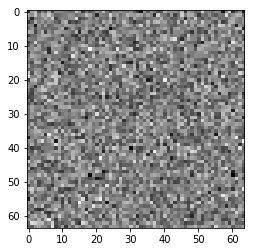

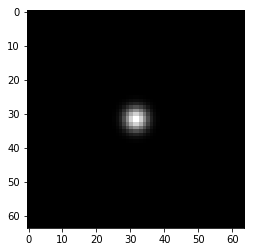

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import scipy.ndimage as snd
import numpy as np

# Generate sample images
mean_noise = 128

# Create measurement noise
noise = np.random.normal(mean_noise,mean_noise**(0.5),(64,64))
# Create signal image
signal = np.zeros((64,64))
signal[30:34,31:33] = 255
signal[31:33,30:34] = 255

# Apply Gaussian kernel to signal image
signal = snd.filters.gaussian_filter(signal,2)

# Get histogram
plt.figure()
plt.imshow(noise,cmap='gray')
plt.figure()
plt.imshow(signal,cmap='gray')
plt.show()
